## Importing libraries

In [ ]:
!pip install praw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 3.8 MB/s eta 0:00:00


In [ ]:
import praw
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import community.community_louvain as community_louvain
from networkx.algorithms.link_prediction import jaccard_coefficient, adamic_adar_index


## Scraping data from Reddit API

In [ ]:
import nest_asyncio
import warnings
import logging
import time

nest_asyncio.apply()

# Suppressing the warnings
warnings.filterwarnings("ignore", category=UserWarning, module="praw")
logger = logging.getLogger("praw")
logger.setLevel(logging.CRITICAL)

import os
from dotenv import load_dotenv

load_dotenv()

reddit = praw.Reddit(
    client_id=os.getenv("CLIENT_ID"),
    client_secret=os.getenv("CLIENT_SECRET"),
    user_agent=os.getenv("USER_AGENT")
)

# Scraping parameters
subreddit_name = "AskReddit"
post_limit = 100  # Number of posts to scrape
node_limit = 300  # Maximum number of unique users to collect

# Function to scrape Reddit posts & interactions
def scrape_reddit(subreddit_name, post_limit, node_limit):
    subreddit = reddit.subreddit(subreddit_name)
    interactions = set()  # Use a set to remove duplicate interactions
    user_count = {}  # Track unique users

    for post in subreddit.hot(limit=post_limit):
        post.comments.replace_more(limit=5)  # Avoids deep comment trees
        for comment in post.comments.list():
            if comment.parent_id != post.id:  # If it's a reply
                try:
                    parent_author = reddit.comment(comment.parent_id.split('_')[1]).author
                    if parent_author and comment.author:  # Ensures both users exist
                        parent_name = parent_author.name
                        commenter_name = comment.author.name

                        # To Track unique users
                        user_count[parent_name] = user_count.get(parent_name, 0) + 1
                        user_count[commenter_name] = user_count.get(commenter_name, 0) + 1

                        # Stopping if node limit reached
                        if len(user_count) >= node_limit:
                            print(f"Node limit reached: {node_limit} users collected.")
                            return list(interactions)

                        # Adding valid interaction
                        interactions.add((parent_name, commenter_name))
                except:
                    continue

    return list(interactions)

print(f"Scraping {subreddit_name} with a node limit of {node_limit}...")
askreddit_interactions = scrape_reddit(subreddit_name, post_limit, node_limit)

# Converting to DataFrame
df_raw = pd.DataFrame(askreddit_interactions, columns=["User_A", "User_B"])

# Saving the data file
df_raw.to_csv("askreddit_raw_network.csv", index=False)

# Displaying first few interactions
print(df_raw.head())

Scraping AskReddit with a node limit of 300...
Node limit reached: 300 users collected.
                User_A               User_B
0           Dr-McLuvin         HatterTheSad
1             Jubba911     brodievonorchard
2         NeCede_Malis     garden_dragonfly
3         Freedmonster  aglobalvillageidiot
4  MATE_AS_IN_SHIPMATE     provocative_bear


## Preprocessing and cleaning the collecetd data

In [ ]:
# Loading the raw data file
df_raw = pd.read_csv("askreddit_raw_network.csv")

# Building the Graph
G = nx.Graph()
G.add_edges_from(df_raw.values)

# Removing self-loops
G.remove_edges_from([(n, n) for n in G.nodes if G.has_edge(n, n)])

# Removing bots & deleted users
bots_deleted = ["bot", "moderator", "deleted"]
filtered_edges = [(u, v) for u, v in G.edges if not any(b in u.lower() or b in v.lower() for b in bots_deleted)]
G = nx.Graph()
G.add_edges_from(filtered_edges)

# Removing isolated nodes (nodes with degree = 0)
isolated_nodes = list(nx.isolates(G))
G.remove_nodes_from(isolated_nodes)

# Converting cleaned data back to DataFrame
cleaned_edges = list(G.edges())
df_cleaned = pd.DataFrame(cleaned_edges, columns=["User_A", "User_B"])
df_cleaned.to_csv("askreddit_cleaned_network.csv", index=False)

# Displaying first few cleaned interactions
print(df_cleaned.head())

           User_A             User_B
0      Dr-McLuvin       HatterTheSad
1      Dr-McLuvin     standardtissue
2      Dr-McLuvin          GhettoDuk
3      Dr-McLuvin  TheDakestTimeline
4  standardtissue             monjoe


## Building the Network

In [ ]:
# Loading the preprocessed network data
df_cleaned = pd.read_csv("askreddit_cleaned_network.csv")

# Creating a graph
G = nx.Graph()
G.add_edges_from(df_cleaned.values)

print(f"Network built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Network built with 298 nodes and 312 edges.


Nodes (298) → Each node represents a unique Reddit user who has interacted within the subreddit.

Edges (312) → Each edge represents a user replying to another user's comment.

## Network Analysis

### Community Detection Using Louvain Method

In [ ]:
import community.community_louvain as community_louvain

# Applying Louvain Community Detection
partition = community_louvain.best_partition(G)
num_communities = len(set(partition.values()))

print(f"Detected {num_communities} communities.")

# Storing community labels
df_cleaned["Community_A"] = df_cleaned["User_A"].map(partition)
df_cleaned["Community_B"] = df_cleaned["User_B"].map(partition)

df_cleaned.to_csv("askreddit_community_labeled.csv", index=False)
print(df_cleaned.head(10))

Detected 34 communities.
              User_A             User_B  Community_A  Community_B
0         Dr-McLuvin       HatterTheSad            2            2
1         Dr-McLuvin     standardtissue            2            2
2         Dr-McLuvin          GhettoDuk            2            0
3         Dr-McLuvin  TheDakestTimeline            2            2
4     standardtissue             monjoe            2            2
5          GhettoDuk        Cheeky_Star            0            3
6          GhettoDuk   ElegantDreamgirl            0            0
7  TheDakestTimeline       cawkstrangla            2            2
8  TheDakestTimeline             monjoe            2            2
9  TheDakestTimeline           md22mdrx            2            2


If both users have the same community number, they are interacting within the same community and if they have different numbers, it means they are bridging across communities (potentially high betweenness centrality).

## Interactive Visualization of the detected communities

In [ ]:
!pip install pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.3 MB/s eta 0:00:00


In [ ]:
from pyvis.network import Network
from IPython.core.display import display, HTML


# Assigning colors to communities
community_colors = {node: f"hsl({int(360 * partition[node] / num_communities)}, 100%, 70%)" for node in G.nodes()}

# Initializing PyVis network
net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white", notebook=True, cdn_resources="remote")
net.barnes_hut()

# Adding nodes with community-based colors
for node in G.nodes():
    community_id = partition[node]
    color = community_colors[node]
    title = f"Community: {community_id}"
    net.add_node(node, label=node, title=title, color=color, size=15)

# Adding edges
for edge in G.edges():
    net.add_edge(edge[0], edge[1])

# Displaying the network
display(HTML(net.generate_html()))



## Computing Centrality measures

In [ ]:
# Computing Centrality Measures
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)
clustering_coeff = nx.clustering(G)
pagerank = nx.pagerank(G)

# Storing the results into DataFrame
df_centrality = pd.DataFrame({
    "User": list(G.nodes()),
    "Degree Centrality": [degree_centrality[user] for user in G.nodes()],
    "Betweenness Centrality": [betweenness_centrality[user] for user in G.nodes()],
    "Closeness Centrality": [closeness_centrality[user] for user in G.nodes()],
    "Eigenvector Centrality": [eigenvector_centrality[user] for user in G.nodes()],
    "Clustering Coefficient": [clustering_coeff[user] for user in G.nodes()],
    "PageRank": [pagerank[user] for user in G.nodes()]
})


## Showing plots

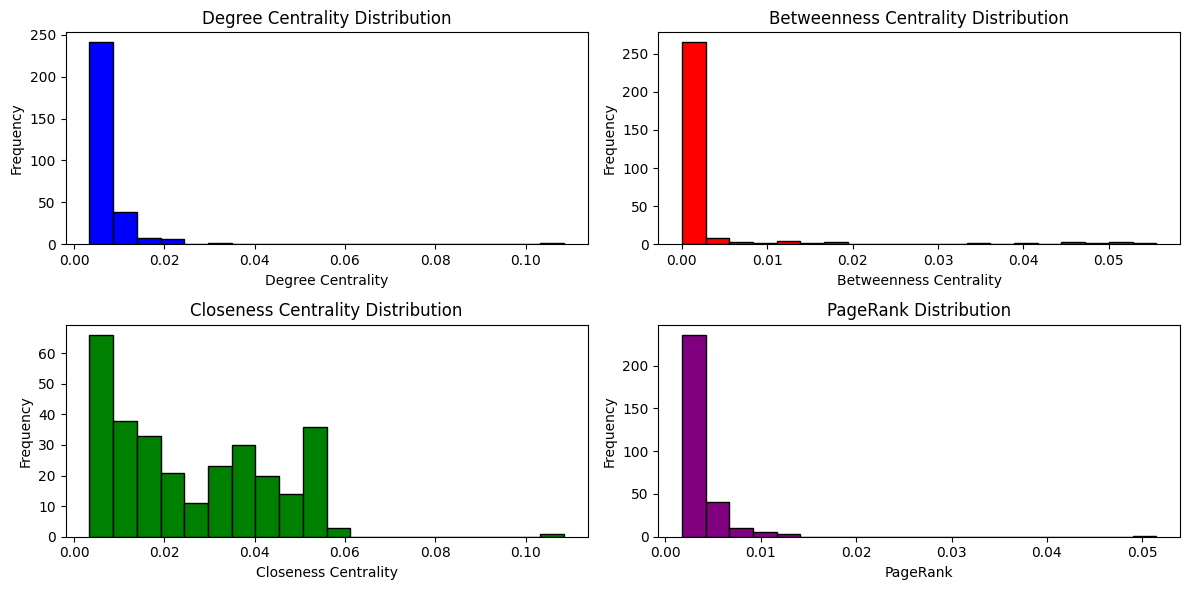

In [ ]:
import matplotlib.pyplot as plt

# Plot Centrality Distributions
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.hist(degree_centrality.values(), bins=20, color="blue", edgecolor="black")
plt.title("Degree Centrality Distribution")
plt.xlabel("Degree Centrality")
plt.ylabel("Frequency")

plt.subplot(2, 2, 2)
plt.hist(betweenness_centrality.values(), bins=20, color="red", edgecolor="black")
plt.title("Betweenness Centrality Distribution")
plt.xlabel("Betweenness Centrality")
plt.ylabel("Frequency")

plt.subplot(2, 2, 3)
plt.hist(closeness_centrality.values(), bins=20, color="green", edgecolor="black")
plt.title("Closeness Centrality Distribution")
plt.xlabel("Closeness Centrality")
plt.ylabel("Frequency")

plt.subplot(2, 2, 4)
plt.hist(pagerank.values(), bins=20, color="purple", edgecolor="black")
plt.title("PageRank Distribution")
plt.xlabel("PageRank")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


All centrality measures follow a long-tail distribution, where a few users are extremely influential while most have low connectivity.

## Heatmap showing Influence Metrics

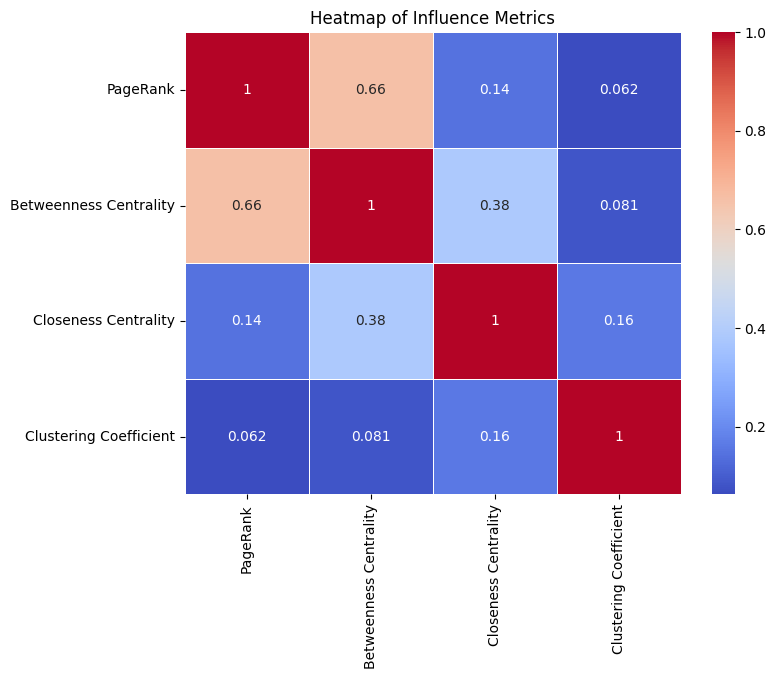

In [ ]:
import seaborn as sns

# Extracting centrality scores for heatmap
centrality_matrix = df_centrality[
    ["PageRank", "Betweenness Centrality", "Closeness Centrality", "Clustering Coefficient"]
].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(centrality_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Heatmap of Influence Metrics")
plt.show()


PageRank & Betweenness are the strongest influencers in the network.
Clustering Coefficient has little influence on PageRank, showing globally important nodes are not necessarily well-clustered.

## Tabular output showing Top 10 Influential Users based on PageRank

In [ ]:
from tabulate import tabulate

# Sorting by PageRank (Influence Metric)
df_centrality = df_centrality.sort_values(by="PageRank", ascending=False)

# Displaying Top 10 Influential Users
print("\nTop 10 Influential Users (Based on PageRank):")
print(tabulate(df_centrality.head(10), headers='keys', tablefmt='pretty'))

# Saving results
df_centrality.to_csv("askreddit_centrality_measures.csv", index=False)
print("Centrality measures saved to askreddit_centrality_measures.csv")


Top 10 Influential Users (Based on PageRank):
+-----+---------------------+----------------------+------------------------+----------------------+------------------------+------------------------+----------------------+
|     |        User         |  Degree Centrality   | Betweenness Centrality | Closeness Centrality | Eigenvector Centrality | Clustering Coefficient |       PageRank       |
+-----+---------------------+----------------------+------------------------+----------------------+------------------------+------------------------+----------------------+
| 47  |      Plucault       | 0.050505050505050504 |  0.05218096884763549   | 0.15005123700775874  |   0.4413479146219787   |  0.02857142857142857   | 0.02041829714799008  |
| 24  | MATE_AS_IN_SHIPMATE | 0.04713804713804714  |  0.10163345163345162   | 0.15117341506230395  |  0.35446727141936824   |  0.01098901098901099   | 0.01933908186376972  |
| 181 |      hopey7tm       | 0.043771043771043766 |  0.05777308693975367   | 0.144

## Computing Edge weight

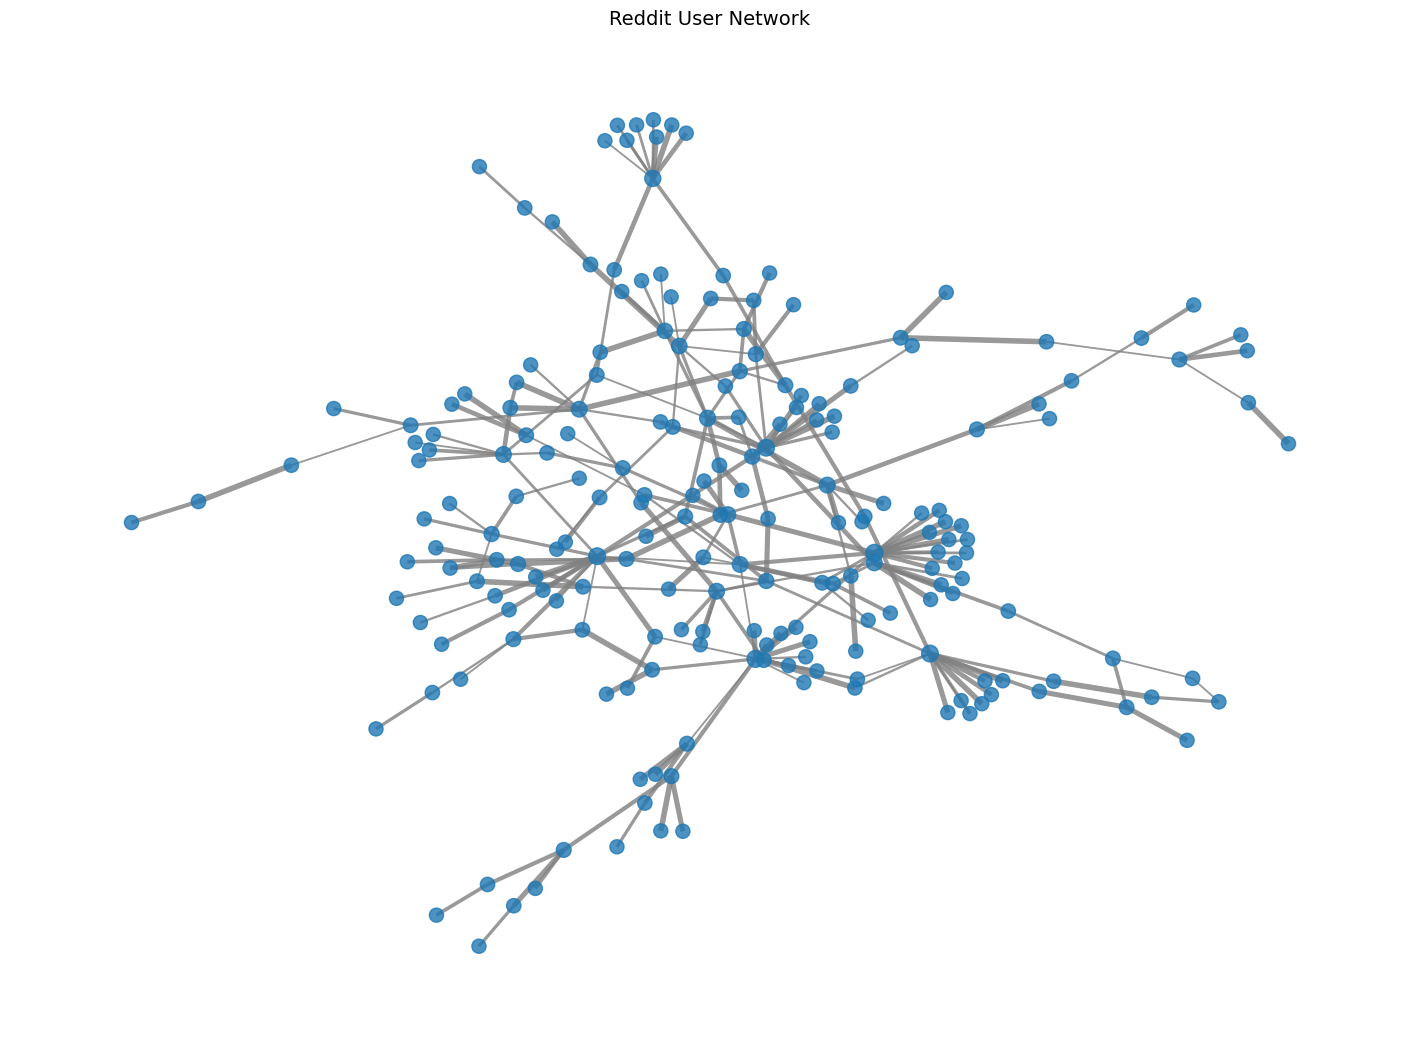

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Computing edge weights based on interaction frequency
edge_weights = {edge: np.random.randint(1, 10) for edge in G.edges()}

# Normalizing edge weights
max_weight = max(edge_weights.values()) if edge_weights else 1
normalized_weights = {e: (edge_weights[e] / max_weight) * 3 + 1 for e in G.edges()}

# Node size scaling
node_sizes = {n: 100 + 1000 * degree_centrality[n] for n in G.nodes()}  # Use a dictionary

# largest connected component
largest_cc = max(nx.connected_components(G), key=len)
G_largest = G.subgraph(largest_cc)

# Generating positions for layout
pos = nx.spring_layout(G_largest, seed=42)

# Displaying figure
plt.figure(figsize=(14, 10))
nx.draw(
    G_largest, pos,
    node_size=[node_sizes[n] for n in G_largest.nodes()],  # Corrected dictionary lookup
    edge_color="gray",
    width=[normalized_weights[e] for e in G_largest.edges()],
    alpha=0.8
)

plt.title("Reddit User Network", fontsize=14)
plt.show()

Edge weights represent the frequency of interactions between two users.
A community with many thick edges indicate highly active discussions.
Sparse/thin edges indicate occasional interactions.


## Visualizing Influence Network with Top 10 influencers

In [ ]:
import plotly.graph_objects as go
import networkx as nx
import community.community_louvain as community_louvain
import numpy as np
import matplotlib.colors as mcolors

# Generating distinct colors for each community
color_map = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
community_colors = {i: color_map[i % len(color_map)] for i in range(num_communities)}

# ForceAtlas2 layout for better spacing
pos = nx.spring_layout(G, seed=42, k=0.2, iterations=50)

# Extracting node positions, attributes
node_x, node_y, node_color, node_size = [], [], [], []
pagerank_values = np.array([pagerank[node] for node in G.nodes()])
norm_pagerank = (pagerank_values - pagerank_values.min()) / (pagerank_values.max() - pagerank_values.min())

# Identifying top influencers
top_influencers = sorted(pagerank, key=pagerank.get, reverse=True)[:10]

for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

    # Assigning colors based on community detection
    node_color.append(community_colors[partition[node]])

    # Assigning node size based on PageRank
    node_size.append(10 + 80 * norm_pagerank[list(G.nodes()).index(node)])

# Extracting edge positions
edge_x, edge_y = [], []

for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

# Creating edge trace
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color="gray"),
    hoverinfo="none",
    mode="lines"
)

# Creates node trace
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode="markers+text",
    text=[f"User: {node}<br>Community: {partition[node]}" if node in top_influencers else "" for node in G.nodes()],
    textposition="top center",
    marker=dict(
        size=node_size,
        color=node_color,
        opacity=0.9,  # Reduces opacity for smaller nodes
        line=dict(width=1.5, color="black")
    ),
    hoverinfo="text"
)

# Creating the figure
fig = go.Figure(data=[edge_trace, node_trace])
fig.update_layout(
    title="Community Network",
    titlefont_size=16,
    showlegend=False,
    hovermode="closest",
    margin=dict(b=0, l=0, r=0, t=40),
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    paper_bgcolor="#111111"
)

fig.show()

Some large clusters suggest strongly connected groups, where users frequently interact. These groups might be interest-based subcommunities (e.g., users engaging in the same topic).

Some users act as bridges between communities.
These are important influencers because they connect otherwise separate groups.

Dense regions indicates active discussions and closely-knit groups.
Sparse areas indicates isolated users or less frequent interactions.

## Analyzing community vs Global influence using Simpson’s Paradox

In [ ]:
import pandas as pd

# Computing centrality measures of global influence
global_pagerank = nx.pagerank(G)
global_betweenness = nx.betweenness_centrality(G)

# Community-wise centrality
community_pagerank = {}
community_betweenness = {}

for community_id in set(partition.values()):
    subgraph_nodes = [node for node in G.nodes() if partition[node] == community_id]
    subgraph = G.subgraph(subgraph_nodes)
    community_pagerank[community_id] = nx.pagerank(subgraph)
    community_betweenness[community_id] = nx.betweenness_centrality(subgraph)

# Storing results in DataFrame
df_paradox = pd.DataFrame({
    "User": list(global_pagerank.keys()),
    "Global_PageRank": [global_pagerank[user] for user in global_pagerank],
    "Global_Betweenness": [global_betweenness[user] for user in global_betweenness],
    "Community": [partition[user] for user in global_pagerank]
})

# Mapping community-specific centrality
df_paradox["Community_PageRank"] = df_paradox.apply(lambda row: community_pagerank[row["Community"]].get(row["User"], 0), axis=1)
df_paradox["Community_Betweenness"] = df_paradox.apply(lambda row: community_betweenness[row["Community"]].get(row["User"], 0), axis=1)

# Displaying users where paradox may exist
df_paradox_sorted = df_paradox.sort_values(by="Global_PageRank", ascending=False)
print(tabulate(df_paradox_sorted.head(15), headers='keys', tablefmt='pretty'))

+-----+---------------------+----------------------+------------------------+-----------+---------------------+-----------------------+
|     |        User         |   Global_PageRank    |   Global_Betweenness   | Community | Community_PageRank  | Community_Betweenness |
+-----+---------------------+----------------------+------------------------+-----------+---------------------+-----------------------+
| 47  |      Plucault       | 0.02041829714799008  |  0.05218096884763549   |    13     | 0.24704383192908336 |  0.7509881422924901   |
| 24  | MATE_AS_IN_SHIPMATE | 0.01933908186376972  |  0.10163345163345162   |     5     | 0.21694058780150807 |  0.8181818181818181   |
| 181 |      hopey7tm       | 0.016813235324743683 |  0.05777308693975367   |    24     | 0.2419138582944077  |  0.8128654970760234   |
| 32  |   KneeDeepThought   | 0.016134565154279402 |   0.1223344901375203   |    26     |  0.177353406525802  |  0.6152832674571804   |
| 15  |     Scaryclouds     | 0.0157283241113271

Users with high Global PageRank may have low Community PageRank.
→ Example: Plucault has a high global PageRank (0.0204) but is not the most dominant locally (0.2470).
Some users have low Global PageRank but are dominant in their community.
→ Example: madcats323 has a low global PageRank (0.0143) but is the most influential in their community (0.4684).

## Visualization showing Simpson’s Paradox for Community vs. Global Influence

---



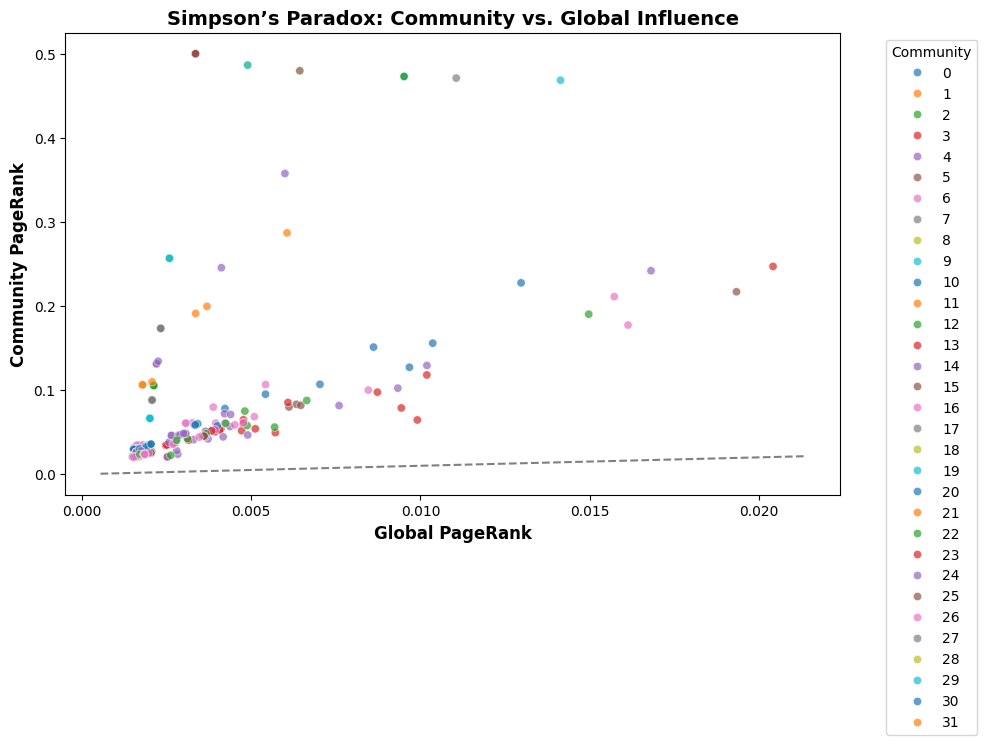

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Creating the figure
plt.figure(figsize=(10, 6))

# Scatter plot with colors based on Community
sns.scatterplot(
    data=df_paradox,
    x="Global_PageRank",
    y="Community_PageRank",
    hue="Community",
    palette="tab10",
    alpha=0.7
)

# Assigning x and y labels
plt.xlabel("Global PageRank", fontsize=12, fontweight="bold")
plt.ylabel("Community PageRank", fontsize=12, fontweight="bold")
plt.title("Simpson’s Paradox: Community vs. Global Influence", fontsize=14, fontweight="bold")
plt.legend(title="Community", bbox_to_anchor=(1.05, 1), loc="upper left")
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
plt.plot([x_min, x_max], [x_min, x_max], linestyle="--", color="gray")  # Align reference line

# Displaying the plot
plt.show()


A dot far to the right but low on the Y-axis are the users globally influential but may not dominate within their own communities.
Dots high on the Y-axis but far left on the X-axis are are locally influential but don’t play a major role in the overall network.